In [14]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import catboost as cb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pprint
from typing import *
import lightgbm as lgb
from catboost import CatBoostClassifier
from ktools.preprocessing.categorical_string_label_error_imputator import CategoricalLabelErrorImputator
from ktools.preprocessing.categorical_features_embedder import SortMainCategories
from ktools.preprocessing.kaggle_dataset_manager import KaggleDatasetManager

In [15]:
df = pd.read_csv("data/poisonous_mushrooms/train.csv", index_col=0)
test_df = pd.read_csv("data/poisonous_mushrooms/test.csv", index_col=0)

In [16]:
categorical_col_names = [col_name for col_name in df.columns if df[col_name].dtype == 'object']
test_categorical_col_names = categorical_col_names.copy()
test_categorical_col_names.remove('class')
categorical_col_names

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [17]:
df = CategoricalLabelErrorImputator().impute(df.copy(),
                                            categorical_col_names,
                                            10)
test_df = CategoricalLabelErrorImputator().impute(test_df.copy(),
                                                test_categorical_col_names,
                                                10)

In [6]:
# for col in df.columns:
#     if df[col].dtype == "object" and col != 'class':
#         print(col, test_df[col].value_counts().index.tolist())
#         print(test_df[col].value_counts().values)

In [18]:
smc_object = SortMainCategories(df,
                   categorical_col_names,
                   500,
                   False)

encoded_df, encoded_test_df = smc_object.sort(df), smc_object.sort(test_df)

In [19]:
X_cols = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season']
y_cols = ["class"]

In [31]:
data_manager = KaggleDatasetManager(encoded_df,
                                    X_cols,
                                    y_cols[0],
                                    0.95,
                                    0.05,
                                    0)

(X_train, 
X_valid, 
X_test, 
y_train, 
y_valid, 
y_test) = data_manager.dataset_partition()

In [314]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'CPU',
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [32]:
# xgb_params = {
#     'n_estimators': 2407,
#     'eta': 0.009462133032592785,
#     'gamma': 0.2865859948765318,
#     'max_depth': 31,
#     'min_child_weight': 47,
#     'subsample': 0.6956431754146083,
#     'colsample_bytree': 0.3670732604094118,
#     'grow_policy': 'lossguide',
#     'max_leaves': 73,
#     'n_jobs': -1,
#     'tree_method': 'hist'
# }

# xgb_params = {'n_estimators': 297, 
#             'max_depth': 16, 
#             'learning_rate': 0.03906159386409017, 
#             'subsample': 0.6935900010487451, 
#             'colsample_bytree': 0.5171160704967471, 
#             'gamma': 0.00013710778966124443, 
#             'lambda': 0.0017203271581656767, 
#             'alpha': 8.501510750413265e-06}

xgb_params = {'max_depth': 34, 
            'learning_rate': 0.009195574997217204, 
            'gamma': 0.947452139226582, 
            'subsample': 0.7048675112537893, 
            'colsample_bytree': 0.36816717431780044, 
            'lambda': 0.003497277552749157, 
            'alpha': 1.8894975902136887e-08, 
            'max_leaves': 478,
            'n_estimators' : 3000}



# xgb_params = {}

model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        # tree_method='gpu_hist'
                        )
model.fit(X_train, 
            y_train)

XGBClassifier(alpha=1.8894975902136887e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.36816717431780044, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.947452139226582, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.003497277552749157,
              learning_rate=0.009195574997217204, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=34, max_leaves=478,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None, ...)

In [33]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy:.4f}")

Final Model Accuracy: 0.9924


In [34]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(model.predict(encoded_test_df[X_cols])).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v11.csv")

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring='matthews_corrcoef')
cv_results.mean()

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/training.py", line 182, in train
    if cb_container.after_iteration(bst, i, dtrain, evals):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/callback.py", line 261, in after_iteration
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/callback.py", line 261, in <genexpr>
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/callback.py", line 446, in after_iteration
    raise ValueError(msg)
ValueError: Must have at least 1 validation dataset for early stopping.


In [331]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(silent=True)
lgb = lgb.LGBMClassifier()

# Define the stacking ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgb', lgb)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Train the ensemble model
stacking_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:26:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:27:46] WARNING: /Users/r

Ensemble Model Accuracy: 0.9916


Accuracy: 0.992313


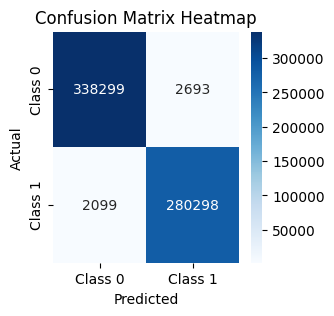

In [253]:
y_pred = default_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy: 0.988413


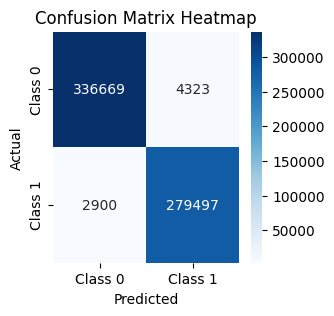

In [256]:
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

Accuracy: 0.991363


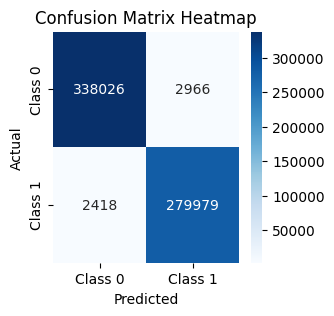

In [255]:
catboost_model = CatBoostClassifier(silent=True)
catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
default_model = XGBClassifier(**xgb_params)
# Train the model
default_model.fit(X_train, y_train)

In [259]:
encoded_test_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class_1
id,,,,,,,,,,,,,,,,,,,,,
3116945,8.64,0,-1,0,1,-1,-1,0,11.13,17.12,...,-1,0,0,0,1,6,-1,0,0,NaN
3116946,6.90,4,0,5,0,-1,0,2,1.27,10.75,...,-1,1,-1,-1,0,0,-1,0,0,NaN
3116947,2.00,3,4,0,0,-1,0,1,6.18,3.14,...,-1,1,-1,-1,0,0,-1,0,3,NaN
3116948,3.47,0,0,0,0,4,0,1,4.98,8.51,...,-1,0,-1,2,1,2,-1,0,1,NaN
3116949,6.17,0,3,1,0,5,-1,2,6.73,13.70,...,-1,2,-1,1,1,-1,-1,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.88,0,4,2,0,0,1,0,2.67,1.35,...,-1,5,-1,-1,0,0,-1,0,1,NaN
5194905,3.12,0,1,2,0,1,0,0,2.69,7.38,...,-1,0,-1,-1,0,0,-1,1,0,NaN
5194906,5.73,0,7,4,0,0,-1,0,6.16,9.74,...,-1,2,-1,0,1,2,-1,0,0,NaN


In [298]:
class_mapping = {0 : 'p', 1 : 'e'}

encoded_test_df["class_1"] = pd.Series(default_model.predict(encoded_test_df[X_cols])).to_list()
encoded_test_df["class_2"] = pd.Series(lgb_model.predict(encoded_test_df[X_cols])).to_list()
encoded_test_df["class_3"] = pd.Series(catboost_model.predict(encoded_test_df[X_cols])).to_list()

In [308]:
encoded_test_df["class"] = (encoded_test_df[["class_1", "class_2", "class_3"]].sum(axis=1) > 2).astype(int).apply(lambda x : class_mapping[x])

In [309]:
encoded_test_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class_1,class_2,class_3,class
id,,,,,,,,,,,,,,,,,,,,,
3116945,8.64,0,-1,0,1,-1,-1,0,11.13,17.12,...,0,1,6,-1,0,0,1,1,1,e
3116946,6.90,4,0,5,0,-1,0,2,1.27,10.75,...,-1,0,0,-1,0,0,0,0,0,p
3116947,2.00,3,4,0,0,-1,0,1,6.18,3.14,...,-1,0,0,-1,0,3,0,0,0,p
3116948,3.47,0,0,0,0,4,0,1,4.98,8.51,...,2,1,2,-1,0,1,0,0,0,p
3116949,6.17,0,3,1,0,5,-1,2,6.73,13.70,...,1,1,-1,-1,0,1,1,1,1,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.88,0,4,2,0,0,1,0,2.67,1.35,...,-1,0,0,-1,0,1,0,0,0,p
5194905,3.12,0,1,2,0,1,0,0,2.69,7.38,...,-1,0,0,-1,1,0,0,0,0,p
5194906,5.73,0,7,4,0,0,-1,0,6.16,9.74,...,0,1,2,-1,0,0,0,0,0,p


In [347]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(default_model.predict(encoded_test_df[X_cols])).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v8.csv")

In [64]:
# df.isna().sum(axis=1)/df.shape[1]

# Catboost

In [18]:
df.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

In [19]:
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,-1,-1,w,-1,-1,f,f,-1,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,-1,y,o,-1,-1,t,z,-1,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,-1,s,n,-1,-1,f,f,-1,l,w
3,e,3.88,f,y,g,f,s,-1,g,4.16,...,-1,-1,w,-1,-1,f,f,-1,d,u
4,e,5.85,x,l,w,f,d,-1,w,3.37,...,-1,-1,w,-1,-1,f,f,-1,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.29,f,-1,n,t,-1,-1,w,12.14,...,b,-1,w,u,w,t,g,-1,d,u
3116941,e,10.88,s,-1,w,t,d,c,p,6.65,...,-1,-1,w,-1,-1,f,f,-1,d,u
3116942,p,7.82,x,e,e,f,a,-1,w,9.51,...,-1,-1,y,-1,w,t,z,-1,d,a


In [41]:
X_cols = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season']
y_cols = ["class"]
X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[y_cols], test_size=0.2, random_state=42)

In [31]:
categorical_features = [col_name for col_name in df if df[col_name].dtype == 'object' and col_name != 'class']

In [24]:
def objective(trial):

    # Define the hyperparameter space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'task_type': 'CPU',
        'cat_features' : [col_name for col_name in df if df[col_name].dtype == 'object' and col_name != 'class']
    }

    # Create the CatBoost model with the suggested parameters
    model = cb.CatBoostClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # # Fit the model on the training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    # # Predict on the test set
    # y_pred = model.predict(X_test)
    
    # # Calculate accuracy
    # accuracy = accuracy_score(y_test, y_pred)
    
    # Return the accuracy as the objective to maximize
    return scores.mean()

In [36]:
cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'CPU',
    "cat_features": categorical_features
}
model = cb.CatBoostClassifier(**cat_params)
model.fit(X_train, y_train, early_stopping_rounds=50, verbose=10)

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=6))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [28]:
def print_trial_callback(study, trial):
    print(f"Trial {trial.number}")

In [30]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the study with the objective function
study.optimize(objective, n_trials=2, callbacks=print_trial_callback)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

[I 2024-08-18 18:17:03,592] A new study created in memory with name: no-name-caa58d0a-b9c5-45d3-a5dd-33621a743519


0:	learn: 0.6926598	total: 641ms	remaining: 4m 38s
1:	learn: 0.6924810	total: 884ms	remaining: 3m 11s
2:	learn: 0.6919847	total: 1.6s	remaining: 3m 51s
3:	learn: 0.6916154	total: 2.16s	remaining: 3m 52s
4:	learn: 0.6914431	total: 2.27s	remaining: 3m 15s
5:	learn: 0.6910803	total: 2.86s	remaining: 3m 24s
6:	learn: 0.6908018	total: 3.14s	remaining: 3m 11s
7:	learn: 0.6903881	total: 3.68s	remaining: 3m 16s
8:	learn: 0.6900764	total: 4.23s	remaining: 3m 20s
9:	learn: 0.6895220	total: 4.88s	remaining: 3m 27s
10:	learn: 0.6890709	total: 5.43s	remaining: 3m 29s
11:	learn: 0.6886104	total: 5.93s	remaining: 3m 28s
12:	learn: 0.6883064	total: 6.31s	remaining: 3m 24s
13:	learn: 0.6880128	total: 6.8s	remaining: 3m 24s
14:	learn: 0.6876545	total: 7.21s	remaining: 3m 21s
15:	learn: 0.6872052	total: 7.75s	remaining: 3m 22s
16:	learn: 0.6867818	total: 8.38s	remaining: 3m 26s
17:	learn: 0.6862349	total: 8.96s	remaining: 3m 27s
18:	learn: 0.6858786	total: 9.41s	remaining: 3m 26s
19:	learn: 0.6854376	tot

[W 2024-08-18 18:19:46,065] Trial 0 failed with parameters: {'iterations': 435, 'depth': 7, 'learning_rate': 0.0010423984142987218, 'random_strength': 69, 'bagging_temperature': 0.4836207371009318, 'border_count': 47, 'l2_leaf_reg': 0.00814906749982062, 'scale_pos_weight': 1.9188222004022604} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/xs/yw83rqss71nc9hlz48gw8blh0000gn/T/ipykernel_18158/1651761454.py", line 21, in objective
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*

KeyboardInterrupt: 

# XGBOOST model fitting

In [63]:
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,12.14,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,e,10.88,s,NaN,w,t,d,c,p,6.65,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,p,7.82,x,e,e,f,a,NaN,w,9.51,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a


In [64]:
test_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.88,x,g,w,f,a,d,w,2.67,1.35,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
5194905,3.12,x,s,w,f,d,c,w,2.69,7.38,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
5194906,5.73,x,e,e,f,a,NaN,w,6.16,9.74,NaN,NaN,y,NaN,w,t,z,NaN,d,a


In [66]:
assert (df.drop(columns="class").columns == test_df.columns).all()

In [67]:
df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [68]:
df.describe()

,cap-diameter,stem-height,stem-width
count,3.116941e+06,3.116945e+06,3.116945e+06
mean,6.309848e+00,6.348333e+00,1.115379e+01
std,4.657931e+00,2.699755e+00,8.095477e+00
min,3.000000e-02,0.000000e+00,0.000000e+00
25%,3.320000e+00,4.670000e+00,4.970000e+00
50%,5.750000e+00,5.880000e+00,9.650000e+00
75%,8.240000e+00,7.410000e+00,1.563000e+01
max,8.067000e+01,8.872000e+01,1.029000e+02


In [69]:
df.dtypes

class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object

In [70]:
df.head(5)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [82]:
df.isna().sum()

class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

<Axes: >

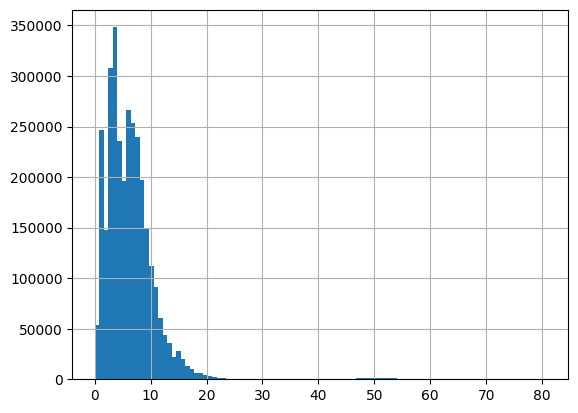

In [71]:
df["cap-diameter"].hist(bins=100)

In [72]:
additional_info = """   1. cap-shape:                bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s,
                        2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s,
                        3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y,
                        4. bruises?:                 bruises=t,no=f,
                        5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s,
                        6. gill-attachment:          attached=a,descending=d,free=f,notched=n,
                        7. gill-spacing:             close=c,crowded=w,distant=d,
                        8. gill-size:                broad=b,narrow=n,
                        9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y,
                        10. stalk-shape:              enlarging=e,tapering=t,
                        11. stalk-root:               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?,
                        12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s,
                        13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s,
                        14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y,
                        15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y,
                        16. veil-type:                partial=p,universal=u,
                        17. veil-color:               brown=n,orange=o,white=w,yellow=y,
                        18. ring-number:              none=n,one=o,two=t,
                        19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z,
                        20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y,
                        21. population:               abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y,
                        22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d,"""

In [13]:
lines = additional_info.split("\n")

In [35]:
pattern = r'\. (.*?)\:'
value_pattern = r'\=(.*?)\,'

accepted_values = {}

for l in lines:
    match = re.findall(pattern, l)[0]
    value = re.findall(value_pattern, l)
    accepted_values[match] = value


In [37]:
accepted_values

{'cap-shape': ['b', 'c', 'x', 'f', 'k', 's'],
 'cap-surface': ['f', 'g', 'y', 's'],
 'cap-color': ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'],
 'bruises?': ['t', 'f'],
 'odor': ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's'],
 'gill-attachment': ['a', 'd', 'f', 'n'],
 'gill-spacing': ['c', 'w', 'd'],
 'gill-size': ['b', 'n'],
 'gill-color': ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'],
 'stalk-shape': ['e', 't'],
 'stalk-root': ['b', 'c', 'u', 'e', 'z', 'r', '?'],
 'stalk-surface-above-ring': ['f', 'y', 'k', 's'],
 'stalk-surface-below-ring': ['f', 'y', 'k', 's'],
 'stalk-color-above-ring': ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
 'stalk-color-below-ring': ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
 'veil-type': ['p', 'u'],
 'veil-color': ['n', 'o', 'w', 'y'],
 'ring-number': ['n', 'o', 't'],
 'ring-type': ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],
 'spore-print-color': ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y'],
 'population': ['a', 'c', 'n', 's', 'v'

In [84]:
# cutoff = 0.001*df.shape[0]
cutoff = 500

In [177]:
for col in df.columns:
    if df[col].dtype == "object" and col != 'class':
        print(col, df[col].value_counts().index.tolist())
        print(test_df[col].value_counts().index.tolist())
        print(df[col].value_counts().values)
        # print(df[col].value_counts().values > cutoff)

cap-shape ['x', 'f', 's', 'b', 'o', 'p', 'c', 'd', 'e', 'n', 't', 'w', 'g', 'y', 'r', 'a', 'u', 'z', 'l', 'i', 'k', 'h', 'm', '8', '3.55', '7 x', '4.97', '3.25', '11.12', '3 x', '4.3', '7.41', '6.21', '8.29', '7.21', '54.78', '2.82', '20.25', '3.52', '3.04', '6.53', '2.63', '3.91', '6.44', '8.3', '7.6', '1.66', '17.44', '4.33', '3.37', '7.43', '9.13', 'ring-type', '19.29', '5 f', '2.85', 'is s', '4.22', '3.6', '21.56', '6 x', '24.16', '10.13', 'b f', 'is p', '0.82', '10.46', '2.77', '2.94', '12.62', '5.15', '19.04', '49.21', '19.06']
['x', 'f', 's', 'b', 'o', 'p', 'c', 'e', 'd', 't', 'n', 'w', 'y', 'a', 'u', 'g', 'l', 'k', 'r', 'z', 'm', 'i', 'h', 'is f', '2.7', '3.15', '5.05', 'cap-diameter', '4.51', '4.86', '0.97', '3.94', '17.89', '6.15', '6.47', '3.23', '2.02', '1.53', '8', '0.74', '6.52', '9.49', '1.25', '51.63', 'p f', '7.21', '3.34', '8.3', '3.32', '19.76', '0.93', '5 f', '4.55', '6.75', 'ring-type', '11.43', '6', '5.59', '4.41', '3.73', '3.47', '4.54']
[1436026  676238  365146 

In [104]:
accepted_values = {}
obj_cols = []
for col in df.columns:
    if df[col].dtype == "object":
        obj_cols += [col]
        k = (df[col].value_counts().values > cutoff).sum()

        print(col, df[col].value_counts().head(k).index.tolist())
        print(df[col].value_counts().head(k).values)

        accepted_values[col] = df[col].value_counts().head(k).index.tolist()

class ['p', 'e']
[1705396 1411549]
cap-shape ['x', 'f', 's', 'b', 'o', 'p', 'c']
[1436026  676238  365146  318646  108835  106967  104520]
cap-surface ['t', 's', 'y', 'h', 'g', 'd', 'k', 'e', 'i', 'w', 'l']
[460777 384970 327826 284460 263729 206832 128875 119712 113440 109840
  44859]
cap-color ['n', 'y', 'w', 'g', 'e', 'o', 'p', 'r', 'u', 'b', 'k', 'l']
[1359542  386627  379442  210825  197290  178847   91838   78236   73172
   61313   59888   39558]
does-bruise-or-bleed ['f', 't']
[2569743  547085]
gill-attachment ['a', 'd', 'x', 'e', 's', 'p', 'f']
[646034 589236 360878 301858 295439 279110 119953]
gill-spacing ['c', 'd', 'f']
[1331054  407932  119380]
gill-color ['w', 'n', 'y', 'p', 'g', 'o', 'k', 'f', 'r', 'e', 'b', 'u']
[931538 543386 469464 343626 212164 157119 127970 119694  62799  56047
  47247  45399]
stem-root ['b', 's', 'r', 'c', 'f']
[165801 116946  47803  28592    597]
stem-surface ['s', 'y', 'i', 't', 'g', 'k', 'h', 'f']
[327610 255500 224346 147974  78080  73383  28283

In [144]:
class PredictMissingValues:

    def __init__(self, df, col_name, training_col_names, fill_value=-1) -> None:
        self.df = df
        self.col_name = col_name
        self.training_col_names = training_col_names
        self.fill_value = fill_value

    def predict(self):
        training_df = self.df[self.df[self.col_name] != self.fill_value]
        testing_df = self.df[self.df[self.col_name] == self.fill_value]

        default_model = XGBClassifier(eval_metric='logloss')
        # Train the model
        default_model.fit(training_df[self.training_col_names], training_df[self.col_name])
        testing_df['predicted_' + self.col_name] = default_model.predict(testing_df[self.training_col_names])
        return testing_df

In [146]:
pmv = PredictMissingValues(encoded_df, 'cap-shape_enc', ['cap-shape_enc', 'cap-surface_enc',
                                                    'cap-color_enc', 'does-bruise-or-bleed_enc', 'gill-attachment_enc',
                                                    'gill-spacing_enc', 'gill-color_enc', 'stem-root_enc',
                                                    'stem-surface_enc', 'stem-color_enc', 'veil-type_enc', 'veil-color_enc',
                                                    'has-ring_enc', 'ring-type_enc', 'spore-print-color_enc', 'habitat_enc',
                                                    'season_enc'])



In [148]:
preddf=pmv.predict()

/var/folders/xs/yw83rqss71nc9hlz48gw8blh0000gn/T/ipykernel_15205/2726259606.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['predicted_' + self.col_name] = default_model.predict(testing_df[self.training_col_names])


In [58]:
# Choose the column to compare with the others
target_column = 'class'

# Calculate correlation matrix
corr_matrix = encoded_df.corr()

# Extract the correlation of the target column with all others
target_corr = corr_matrix[target_column]

print(target_corr)

class                   1.000000
cap-diameter            0.162626
cap-shape              -0.079532
cap-surface            -0.111837
cap-color              -0.077248
does-bruise-or-bleed    0.037434
gill-attachment         0.172799
gill-spacing            0.078149
gill-color             -0.067124
stem-height             0.049740
stem-width              0.169807
stem-root              -0.115421
stem-surface           -0.162695
stem-color             -0.172831
veil-type              -0.050325
veil-color             -0.071141
has-ring               -0.049531
ring-type               0.011617
spore-print-color      -0.089846
habitat                -0.019133
season                  0.109473
Name: class, dtype: float64


In [59]:
spearman_corr = encoded_df.corr(method='spearman')

# Get the correlation of column 'A' with others
print(spearman_corr['class'])

class                   1.000000
cap-diameter            0.198645
cap-shape              -0.092535
cap-surface            -0.090782
cap-color              -0.096452
does-bruise-or-bleed    0.037538
gill-attachment         0.174159
gill-spacing            0.073651
gill-color             -0.090482
stem-height             0.098395
stem-width              0.222021
stem-root              -0.051362
stem-surface           -0.126532
stem-color             -0.203766
veil-type              -0.050576
veil-color             -0.006878
has-ring               -0.049627
ring-type              -0.048486
spore-print-color      -0.117045
habitat                -0.043324
season                  0.088054
Name: class, dtype: float64


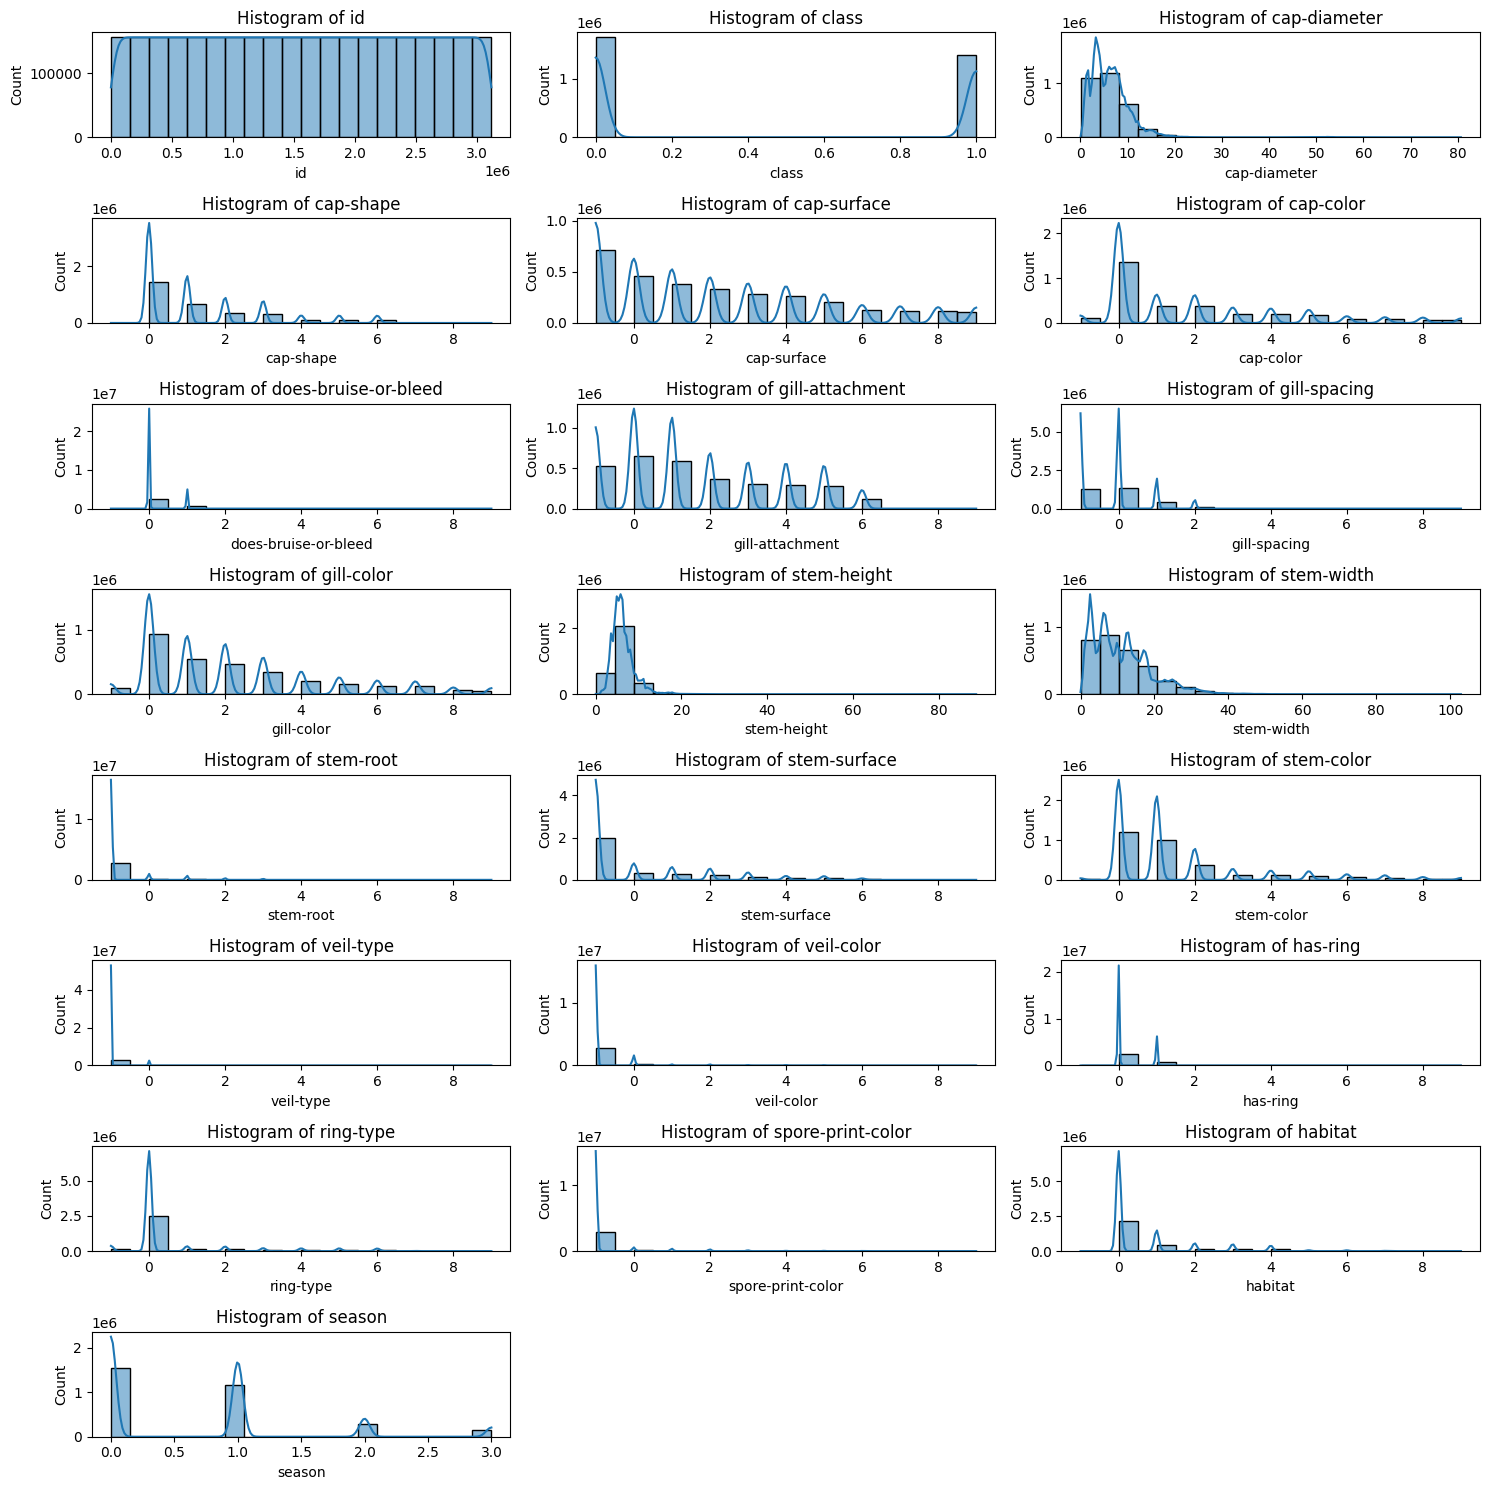

In [58]:
num_columns = len(encoded_df.columns)
num_rows = math.ceil(num_columns / 3)  # You can adjust the number of columns per row as needed

# Create a grid of subplots with exactly the right number of rows
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 15))  # Adjust the figure size as needed

# Flatten the axes array to simplify indexing and handle grids with fewer subplots than axes slots
axes = axes.ravel()

# Loop through columns and plot histograms in the subplots
for i, column in enumerate(encoded_df.columns):
    sns.histplot(encoded_df[column], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

# Hide any remaining empty subplots if there are any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [47]:
X_cols = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season']
y_cols = ["class"]
X_train, X_test, y_train, y_test = train_test_split(encoded_df[X_cols], encoded_df[y_cols], test_size=0.2, random_state=42)

In [40]:
# Initialize the XGBoost classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.2, 0.3],
}

# Initialize the XGBoost classifier
model = XGBClassifier(eval_metric='logloss')
# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=10)
# Perform the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 5/5; 1/18] START learning_rate=0.2, max_depth=5, n_estimators=100...........
[CV 2/5; 2/18] START learning_rate=0.2, max_depth=5, n_estimators=200...........
[CV 3/5; 1/18] START learning_rate=0.2, max_depth=5, n_estimators=100...........
[CV 2/5; 1/18] START learning_rate=0.2, max_depth=5, n_estimators=100...........
[CV 1/5; 1/18] START learning_rate=0.2, max_depth=5, n_estimators=100...........
[CV 3/5; 2/18] START learning_rate=0.2, max_depth=5, n_estimators=200...........
[CV 4/5; 1/18] START learning_rate=0.2, max_depth=5, n_estimators=100...........
[CV 1/5; 2/18] START learning_rate=0.2, max_depth=5, n_estimators=200...........
[CV 1/5; 3/18] START learning_rate=0.2, max_depth=5, n_estimators=300...........
[CV 5/5; 2/18] START learning_rate=0.2, max_depth=5, n_estimators=200...........
[CV 4/5; 2/18] START learning_rate=0.2, max_depth=5, n_estimators=200...........
[CV 2/5; 3/18] START learning_rate=0.2, max_dept

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5; 12/18] START learning_rate=0.3, max_depth=5, n_estimators=300..........
[CV 5/5; 10/18] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.990 total time=  20.0s
[CV 2/5; 12/18] START learning_rate=0.3, max_depth=5, n_estimators=300..........
[CV 1/5; 9/18] END learning_rate=0.2, max_depth=7, n_estimators=300;, score=0.992 total time= 1.1min
[CV 3/5; 12/18] START learning_rate=0.3, max_depth=5, n_estimators=300..........
[CV 2/5; 9/18] END learning_rate=0.2, max_depth=7, n_estimators=300;, score=0.992 total time= 1.1min
[CV 4/5; 12/18] START learning_rate=0.3, max_depth=5, n_estimators=300..........
[CV 3/5; 9/18] END learning_rate=0.2, max_depth=7, n_estimators=300;, score=0.992 total time= 1.2min
[CV 5/5; 12/18] START learning_rate=0.3, max_depth=5, n_estimators=300..........
[CV 1/5; 11/18] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.992 total time=  35.7s
[CV 1/5; 13/18] START learning_rate=0.3, max_depth=6, n_estimators=100..........
[CV 2/5

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3], 'max_depth': [5, 6, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=10)

In [28]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [157]:
# xgb_params = {
#     'n_estimators': 2407,
#     'eta': 0.009462133032592785,
#     'gamma': 0.2865859948765318,
#     'max_depth': 31,
#     'min_child_weight': 47,
#     'subsample': 0.6956431754146083,
#     'colsample_bytree': 0.3670732604094118,
#     'grow_policy': 'lossguide',
#     'max_leaves': 73,
#     'n_jobs': -1,
#     'tree_method': 'hist'
# }

xgb_params = {'n_estimators': 297, 
            'max_depth': 16, 
            'learning_rate': 0.03906159386409017, 
            'subsample': 0.6935900010487451, 
            'colsample_bytree': 0.5171160704967471, 
            'gamma': 0.00013710778966124443, 
            'lambda': 0.0017203271581656767, 
            'alpha': 8.501510750413265e-06}

default_model = XGBClassifier(**xgb_params)
# Train the model
default_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [41]:
# Train the best model on the full training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [57]:
import pickle 

with open('submissions/poisonous_mushrooms/models/model_params.pkl', 'wb') as f:
    pickle.dump(grid_search.best_params_, f)

Accuracy: 0.991909

Classification Report:
              precision    recall  f1-score   support

           0   0.993475  0.991721  0.992597    340992
           1   0.990025  0.992135  0.991079    282397

    accuracy                       0.991909    623389
   macro avg   0.991750  0.991928  0.991838    623389
weighted avg   0.991912  0.991909  0.991909    623389



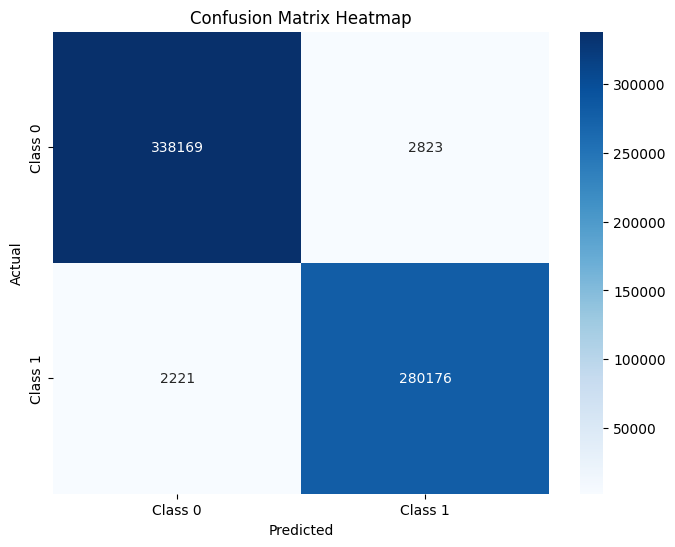

In [42]:
# Predict on the test set
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=6))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

Accuracy: 0.992133

Classification Report:
              precision    recall  f1-score   support

           0   0.993710  0.991897  0.992803    340992
           1   0.990237  0.992418  0.991327    282397

    accuracy                       0.992133    623389
   macro avg   0.991974  0.992158  0.992065    623389
weighted avg   0.992137  0.992133  0.992134    623389



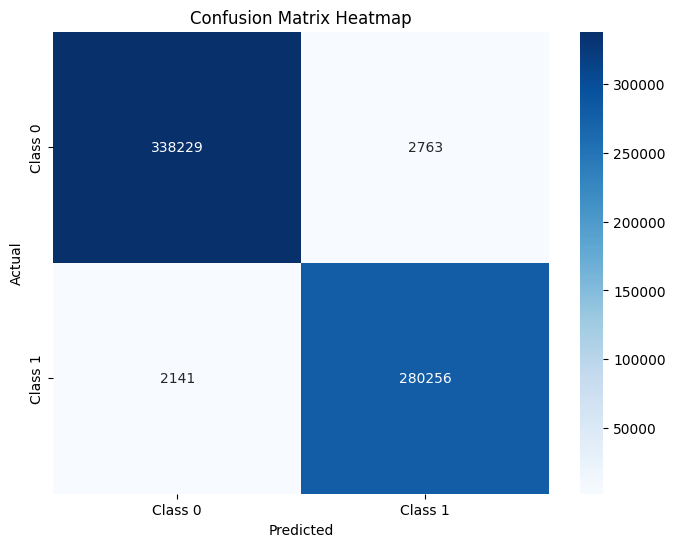

In [49]:
y_pred = default_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=6))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

Accuracy: 0.992313

Classification Report:
              precision    recall  f1-score   support

           0   0.993857  0.992079  0.992967    340992
           1   0.990456  0.992596  0.991525    282397

    accuracy                       0.992313    623389
   macro avg   0.992156  0.992337  0.992246    623389
weighted avg   0.992316  0.992313  0.992314    623389



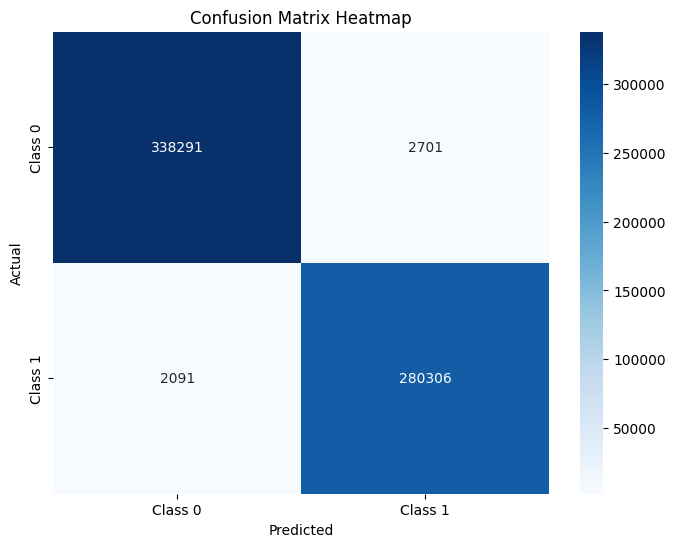

In [203]:
y_pred = default_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=6))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [102]:
default_model.get_booster()


In [32]:
sample_df = pd.read_csv("data/poisonous_mushrooms/sample_submission.csv", index_col=0)

In [33]:
sample_df

,class
id,
3116945,e
3116946,e
3116947,e
3116948,e
3116949,e
...,...
5194904,e
5194905,e
5194906,e


In [39]:
class_mapping = accepted_values['class']
class_mapping = {v : k for k,v in class_mapping.items()}
class_mapping

test_pred = default_model.predict(encoded_test_df)
encoded_test_df["class"] = test_pred
encoded_test_df['class'] = encoded_test_df['class'].apply(lambda x : class_mapping[x])
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v4.csv")

NameError: name 'accepted_values' is not defined

# One-hot encoding

In [112]:
train_cols = df_one_hot.columns.tolist()
train_cols.remove('class')

In [113]:
X_train, X_test, y_train, y_test = train_test_split(df_one_hot[train_cols], df_one_hot['class'], test_size=0.2, random_state=42)

In [114]:
default_model = XGBClassifier(eval_metric='logloss')
# Train the model
default_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.991197

Classification Report:
              precision    recall  f1-score   support

           0   0.993020  0.990871  0.991944    340992
           1   0.989005  0.991590  0.990296    282397

    accuracy                       0.991197    623389
   macro avg   0.991013  0.991230  0.991120    623389
weighted avg   0.991201  0.991197  0.991197    623389



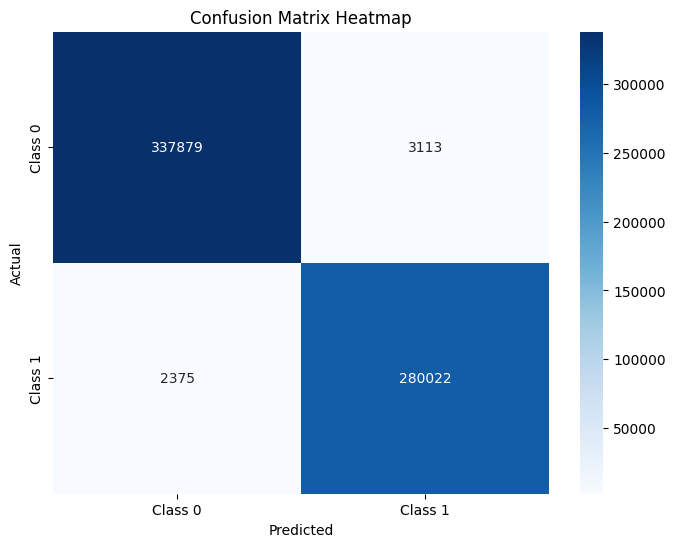

In [115]:
y_pred = default_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=6))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()